In [1]:
import math
import time
import pickle
from random import randint, random
from multiprocessing import Pool, TimeoutError

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm
from IPython.display import clear_output
from nfa_lib import NFA, count_nfa

sns.set()


In [2]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q0'}, '1': {'q3'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q3'}},
        'q6': {'1': {'q4'}},
    },
    initial_states={'q0', 'q1', 'q5', 'q6'},
    final_states={'q2', 'q4', 'q6'}
)

In [3]:
nfa.cycle_height()

2

In [8]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1', 'q2'}},
        'q1': {'0': {'q1', 'q3'}},
        'q2': {'0': {'q3'}, '1': {'q2'} },
        'q3': {'0': {'q3'}},
    },
    initial_states={'q0'},
    final_states={'q3'}
)

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        'q1': {'1': {'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [13]:
%%time
nfa.bruteforce_count_only(20)

100%|██████████| 1048576/1048576 [00:06<00:00, 166056.87it/s]

CPU times: user 6.32 s, sys: 15.8 ms, total: 6.33 s
Wall time: 6.32 s


8

In [ ]:
nfa.plot()

In [ ]:
count, nfa_unroll = count_nfa(nfa, 55, 1500)
count

In [ ]:
x = np.array([1.,2.,3.])


In [ ]:
print(nfa.plot().source)
nfa.plot()

# Experimentos estadísticos

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {
            #'0': {'q1'},
            '1': {'q0', 'q2'}},
        'q2': {
            '1': {'q0'}
        }
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [ ]:
%%time
data = [(i,nfa.bruteforce_count_only(i)/2**i) for i in range(1, 25)]

In [ ]:
log_data = [(i, math.log(max(1, nfa.bruteforce_count_only(i)))) for i in range(1, 24)]

In [38]:
df = pd.DataFrame(log_data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

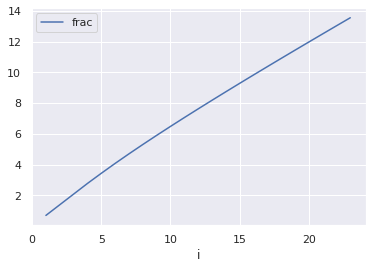

In [39]:
df.plot(x="i", y="frac")

In [20]:
df

,i,frac
0,1,2
1,2,2
2,3,1
3,4,3
4,5,3
5,6,2
6,7,4
7,8,4
8,9,3
9,10,5


In [ ]:
df[df.i >= 5].plot(x="i", y="frac")

In [ ]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [ ]:
predictable_data = df[df.i.between(11,23)]

In [ ]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

In [ ]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

In [ ]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [ ]:
k = 28
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

In [ ]:
[(k,int(fit_function(k, *popt) * 2**k)) for k in range(6,28)]

In [ ]:
{{6, 13},
 {7, 23},
 {8, 44},
 {9, 81},
 {10, 148},
 {11, 274},
 {12, 504},
 {13, 927},
 {14, 1705}}

In [ ]:
%%time
ground_truth_k = nfa.bruteforce_dfs(k)
ground_truth_k

In [ ]:
popt

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|)$ que usa `BFS` y `gcd` para determinar si la densidad del lenguaje es exponencial o polinomial. Se basa en encontrar dos caminos distintos del mismo largo y estado de partida en una componente fuertemente conexa (SCC).
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$
    
- [Scholar Kai Salomaa](https://scholar.google.com/citations?hl=es&user=N3AlqdYAAAAJ&view_op=list_works&sortby=pubdate)

Keeler, Salomaa


$|L(A)| \le \text{ambiguity} \le \text{string path width} \le \text{tree width}$

- **ambiguity**: number of accepting computations of A on a given string
- **string path width**: does not count partial computations, only complete (and maybe non-accepting) computations
- **tree width**: all computations of A on a given string (even partial ones)

In [ ]:
np.random.choice(["-1","0","1"], size=(3,3))[1,0]

In [ ]:
rand = NFA.random(n_states=5, input_symbols={"0", "1"}, sparsity=0.5)
rand.plot()

In [ ]:
rand.bruteforce_count_only(15)

In [ ]:
count, nfa_unroll = count_nfa(rand, 15, 100)
count

In [2]:
with open("intermediate_stats.pkl", "rb") as fd:
    results_stats = pickle.load(fd)
        
df = pd.DataFrame(results_stats, columns=["n_states", "initial_states", "final_states", "transitions",
                                    "string_n", "bruteforce", "estimate", "eps", "time"])
df["rel_error"] = abs(df.estimate - df.bruteforce)/df.bruteforce
def instantiate_nfa(df_row):
    states = {f"q{i}" for i in range(df_row.n_states)}
    nfa = NFA(
        states=states,
        initial_states=df_row.initial_states,
        final_states=df_row.final_states,
        input_symbols={"0", "1"},
        transitions=df_row.transitions,
    )
    return nfa

In [ ]:
timeout = 2400
def compare_random_to_brute(i, nfa: NFA)->list:
    print(f"[{i}] started\n", end="")
    ret_data = []
    start = time.time()
    for string_len in range(4, 5):
        bruteforce = nfa.bruteforce_count_only(string_len)
        if bruteforce == 0:
            continue
        for k_mult_base in range(6, 15):
            k_mult = 2 ** k_mult_base
            try:
                t0 = time.time()
                # Runaway: less than 10 seconds left
                if (t0 - start) > (timeout - 10):
                    continue
                count, nfa_unroll = count_nfa(nfa, string_len, eps=1, kappa_multiple=k_mult)
                t1 = time.time()
                ret_data.append({
                    "n_states": len(nfa.states),
                    "initial_states":nfa.initial_states,
                    "final_states":nfa.final_states,
                    "transitions":nfa.transitions,
                    "string_len": string_len,
                    "bruteforce": bruteforce,
                    "estimate": count,
                    "kappa_multiple": k_mult,
                    "time": t1 - t0,
                })
                rel_error = (count - bruteforce) / bruteforce
                # if low rel_error or the next round will probably take more than remaining time
                remaining_time = timeout - (t1 - start)
                if rel_error < 0.5 or 2 * (t1 - t0) > remaining_time:
                    break
            except Exception as e:
                return e
    return ret_data


# results = [] # n_states, initial_states, final_states, transitions, string_n, bruteforce, estimate, eps, time
samples = 0
errors = []
error_count = 0
n_proc = 6
offset = 0
with Pool(processes=n_proc) as pool:
    sorted_nfas = df.sort_values(by="rel_error", ascending=True).tail(30)
    while offset < 50 and error_count < 3:
        nfa_subset = [instantiate_nfa(row) for row in sorted_nfas.iloc[offset:offset+10].itertuples()]
        multiproc_results = [pool.apply_async(compare_random_to_brute, (i, nfa)) for i, nfa in enumerate(nfa_subset)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get(timeout=timeout)
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                
                results.extend(res)
            offset += 1

        clear_output(wait=True)
        with open("large_error_stats.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")


[0] started
[1] started
[4] started
[5] started


  0%|          | 0/10 [00:00<?, ?it/s]

[2] started
[3] started


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Retries per sample 358015


  0%|          | 0/16 [00:00<?, ?it/s]

Sample size 10496Retries per sample 356414

Sample size 10240
Retries per sample 314647

  0%|          | 0/16 [00:00<?, ?it/s]


Sample size 5376
Retries per sample 325948Retries per sample 343945
Sample size 8448
Retries per sample 354773
Sample size 9984

Sample size 6400

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Layer:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/7 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/5376 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/6400 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Retries per sample 314647
Sample size 10752


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Retries per sample 325948
Sample size 12800


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/8448 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10752 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10496 [00:00<?, ?it/s]

Sampling:   0%|          | 0/9984 [00:00<?, ?it/s]

Sampling:   0%|          | 0/10240 [00:00<?, ?it/s]

Sampling:   0%|          | 0/12800 [00:00<?, ?it/s]

In [6]:
df_kappa = pd.DataFrame(results)

In [7]:
df_kappa

,n_states,initial_states,final_states,transitions,string_len,bruteforce,estimate,kappa_multiple,time
0,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",4,16,55.119722,4,17.601102
1,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",4,16,55.311481,8,32.859440
2,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",4,16,55.747486,16,71.461051
3,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",5,31,149.066297,4,50.961156
4,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",5,31,160.625151,8,104.424047
5,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q2', 'q1'}},...",5,31,156.447535,16,209.917380
6,5,"{q3, q1, q2}",{q3},"{'q0': {'1': {'q3', 'q2', 'q4', 'q0'}, '0': {'...",4,16,23.350601,4,13.813560
7,5,"{q3, q1, q2}",{q3},"{'q0': {'1': {'q3', 'q2', 'q4', 'q0'}, '0': {'...",4,16,23.206019,8,24.952603
8,5,"{q3, q1, q2}",{q3},"{'q0': {'1': {'q3', 'q2', 'q4', 'q0'}, '0': {'...",4,16,22.977379,16,50.174008
9,5,"{q3, q1, q2}",{q3},"{'q0': {'1': {'q3', 'q2', 'q4', 'q0'}, '0': {'...",5,32,60.257846,4,32.507481


In [5]:
errors[:10]

[TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'"),
 TypeError("count_nfa() got an unexpected keyword argument 'epsilon'")]

In [13]:
def cycle_height(row):
    nfa = instantiate_nfa(row)
    return nfa.cycle_height()


In [14]:
df["cycle_height"] = df.apply(cycle_height, axis=1)

In [21]:
df.sort_values(by="rel_error", ascending=False).head(4)

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error,cycle_height
155,5,"{q3, q1, q0}","{q4, q2}","{'q0': {'0': {'q0', 'q2'}, '1': {'q4'}}, 'q1':...",14,16384,910667.905438,54,3016.351845,54.582758,inf
250,5,"{q3, q0, q4, q2}","{q0, q1, q4, q2}","{'q0': {'1': {'q3', 'q4'}, '0': {'q3'}}, 'q1':...",14,6256,346126.976953,28,5106.766545,54.327202,inf
185,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q1', 'q2'}},...",10,1024,25935.479221,43,391.159397,24.327616,inf
439,9,{q8},"{q8, q6}","{'q0': {'1': {'q4', 'q6'}, '0': {'q7'}}, 'q1':...",8,256,4075.632130,88,470.697020,14.920438,inf


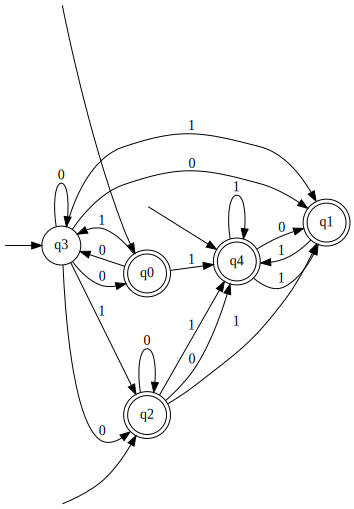

In [23]:
instantiate_nfa(df.loc[250]).plot()

In [4]:
df.sort_values(by="rel_error", ascending=True).tail(50)

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error
375,13,{q0},{q7},"{'q0': {'0': {'q11', 'q8', 'q0'}, '1': {'q5', ...",4,16,71.649313,30,64.562396,3.478082
428,9,"{q0, q7, q8}",{q6},"{'q0': {'1': {'q5', 'q1'}, '0': {'q4', 'q6'}},...",6,32,143.597542,34,147.425944,3.487423
399,14,{q6},"{q11, q10, q2}","{'q0': {'1': {'q5', 'q13', 'q7', 'q4', 'q8'}, ...",7,128,596.716049,78,501.677479,3.661844
279,12,"{q4, q8}","{q0, q2, q7, q9}","{'q0': {'0': {'q5', 'q0', 'q3', 'q1', 'q11', '...",4,16,75.433192,17,168.309165,3.714574
491,7,{q6},"{q0, q3, q1, q4, q2, q6}","{'q0': {'1': {'q0', 'q4'}, '0': {'q5', 'q2', '...",4,16,76.204346,34,5.014052,3.762772
144,6,{q3},"{q5, q2, q1}","{'q0': {'1': {'q5', 'q1'}}, 'q1': {'1': {'q5',...",7,105,501.147921,33,58.171788,3.772837
278,8,{q5},{q2},"{'q0': {'1': {'q0', 'q4', 'q2', 'q7'}, '0': {'...",7,128,618.158367,62,104.309336,3.829362
409,9,{q5},{q4},"{'q0': {'1': {'q0', 'q2', 'q7'}, '0': {'q6'}},...",5,32,155.513995,32,50.662583,3.859812
401,13,{q8},{q6},"{'q0': {'0': {'q10', 'q2', 'q6', 'q0'}, '1': {...",4,16,78.055363,37,40.283245,3.878460
264,9,{q1},"{q0, q6}","{'q0': {'0': {'q0', 'q3', 'q1'}, '1': {'q5', '...",6,63,315.639375,54,68.401093,4.010149


In [ ]:
count_nfa(instantiate_nfa(df))